**1. IMPORTS AND SET UP**

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keybert import KeyBERT
import spacy
import re
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

We create a week column since our goal is to create a clustering per week and team so that the user can know what has happened in that week for each team, by just having a glance diving deeper if interested.

In [3]:
# Load the articles dataset
script_dir = os.path.abspath('')
csv_path = os.path.join(script_dir, "..", "data", "articles_labeled.csv")
articles_df = pd.read_csv(csv_path, sep=";", encoding="utf-16", engine="python")

# Add a 'Week' column based on the 'Date' column
date_format = "%d/%m/%Y %H:%M"
articles_df["Date"] = pd.to_datetime(articles_df["Date"], format=date_format)
articles_df["Week"] = articles_df["Date"].dt.to_period("W")

# Preview the first few rows of the dataset
articles_df.head()

,Full_text,Article_ID,Outlet,Date,Team,Title,Topic,Week
0,Given his current employers’ well-documented i...,755,TheGuardian,2025-07-30 08:07:00,Arsenal,Football transfer rumours: Manchester United m...,0,2025-07-28/2025-08-03
1,Liverpool winger Luis Diaz has completed a £65...,750,BBC,2025-07-30 08:01:00,Liverpool,Bayern Munich sign Liverpool winger Diaz for £65,0,2025-07-28/2025-08-03
2,Manchester United defender Luke Shaw has backe...,751,BBC,2025-07-30 08:00:00,Manchester United,Shaw backs Amorim's hard-line 'demands',4,2025-07-28/2025-08-03
3,Manchester United defender Luke Shaw has sugge...,747,SkySports,2025-07-30 07:47:00,Manchester United,Shaw: There are no stragglers in Man Utd squad...,3,2025-07-28/2025-08-03
4,James Trafford has joined Manchester City from...,748,SkySports,2025-07-29 21:52:00,Manchester City,Man City re-sign Trafford from Burnley,0,2025-07-28/2025-08-03


We visualize the data and embeddings we have using a scatterplot reducing dimensionality with PCA. For the embeddings we use a BERT-based transformers, since in previous testings it is the one that has performed best compared to other methods like TF-IDF vectorization.

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

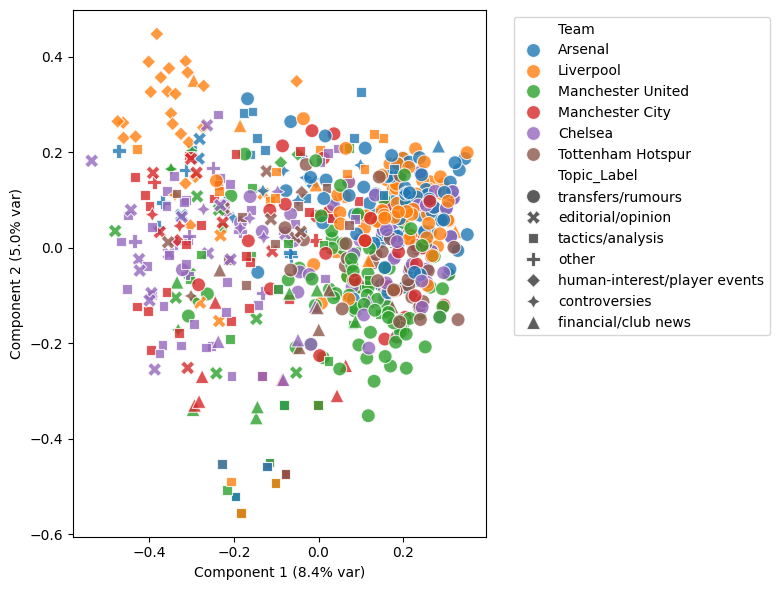

In [ ]:
# Define a mapping for the topics
TOPICS_MAPPING = {
    0: "transfers/rumours",
    1: "financial/club news",
    2: "controversies",
    3: "tactics/analysis",
    4: "editorial/opinion",
    5: "human-interest/player events",
    6: "other"
}

# Load the SentenceTransformer model and PCA
sbert = SentenceTransformer('all-MiniLM-L6-v2')
pca = PCA(n_components=2)

# Embed the articles and reduce dimensionality with PCA
X_emb = sbert.encode(articles_df["Full_text"].tolist(), show_progress_bar=True)
comps = pca.fit_transform(X_emb)
df = articles_df.copy()
df["PC1"], df["PC2"] = comps[:, 0], comps[:, 1]
df["Topic_Label"] = df["Topic"].map(TOPICS_MAPPING)

# Use a color palette for the teams
palette = sns.color_palette("tab10", n_colors=6)  # 6 teams

# Use seaborn to create a scatterplot of the PCA components
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x="PC1", y="PC2",
    hue="Team",           # use team names for color
    palette=palette,
    style="Topic_Label",  # use mapped topic labels for the shape
    s=100,                        
    edgecolor="w",
    alpha=0.8
)

# Add titles and labels
plt.xlabel(f"Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)") 
plt.ylabel(f"Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Firstly, we can see that most of the articles that talk about transfers or rumors, are really close together. We can see more spread in the rest of topics, with some clear clusters like on the top left about human-interest and Liverpool, with articles related with the death of Diogo Jota, or in the bottom with the tactics/analysis articles of different teams, talking most likely about the fixtures for the upcoming season. 

Besides this the PCs only explained about 13% of the variance so we have to look at this plot with a pinch of salt, meaning that there should be more overall separation between points.

**2. EXPLORATION OF MODELS**

We will use different models, but it is key that we select the clusters automatically, so that the pipeline can run without supervision, which is the whole point. For this, we will use the distance-to-line method to select the best possible k, by replicating the elbow rule.

In [ ]:
def calculate_distance(inertias): 
    """ 
    Calculate the best k based on the distance to the line method.

    Args:
        inertias (list): List of inertia values for different k values.
    Returns:
        int: The best k value based on the maximum distance to the linear inertia.
    """

    # Get the first and last inertia values
    lowest_inertia = inertias[-1]
    highest_inertia = inertias[0]

    # If there are not enough inertias, return 0
    if len(inertias) < 2:
        return 0  
    
    # Calculate the step size for linear interpolation
    step = (highest_inertia - lowest_inertia) / (len(inertias)-1)

    # Initialize variables to track the maximum distance and the best k
    max_distance = -np.inf
    best_k = 0

    # Iterate through the inertias to find the best k
    for i in range(len(inertias)):
        # Calculate the linear inertia
        linear_inertia = highest_inertia - i * step
        # Calculate the distance from the linear inertia
        distance = abs(inertias[i] - linear_inertia)

        # Update the maximum distance and best k if the current distance is greater
        if distance > max_distance:
            max_distance = distance
            best_k = i + 1

    return best_k

We ue the k-distance method to determine the optimal eps for DBSCAN clustering.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps(X, min_pts=3, plot=False):
    """ Find the optimal epsilon for DBSCAN using the k-distance method.
    Args:
        X (array-like): Feature matrix.
        min_pts (int): Minimum number of points to consider for the k-distance.
        plot (bool): Whether to plot the k-distance graph.
    Returns:
        float: The optimal epsilon value.
    """

    # If the number of samples is less than min_pts, return 1 ( the avg. eps we have obtained)
    n_samples = X.shape[0]
    if n_samples < min_pts:
        return 1
    
    k = min_pts - 1  # DBSCAN uses MinPts = k+1 (includes the point itself)
    
    # Step 1: Nearest neighbors
    neigh = NearestNeighbors(n_neighbors=k+1)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    # Step 2: Take the k-th nearest neighbor distance
    k_distances = distances[:, k]
    k_distances = np.sort(k_distances)

    # Plot if requested
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(k_distances)
        plt.title(f"k-distance Graph (k={k})")
        plt.xlabel("Points sorted by distance")
        plt.ylabel(f"{k}-NN distance")
        plt.grid(True)
        plt.show()
    
    # Step 3: Elbow detection (distance from line method)
    n_points = len(k_distances)
    all_indices = np.arange(n_points)

    # Line from first to last point
    start = np.array([0, k_distances[0]])
    end = np.array([n_points - 1, k_distances[-1]])
    line_vec = end - start
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    # Translate all points so the first point sits at the origin
    vec_from_start = np.vstack([all_indices, k_distances]).T - start
    # Project each shifted point onto the baseline
    scalar_proj = np.dot(vec_from_start, line_vec_norm)
    proj = np.outer(scalar_proj, line_vec_norm)
    # Compute the vector from each point to its projection
    vec_to_line = vec_from_start - proj
    distances_to_line = np.linalg.norm(vec_to_line, axis=1)

    # Step 4: Choose point with max distance to line
    optimal_idx = np.argmax(distances_to_line)
    optimal_eps = k_distances[optimal_idx]

    return optimal_eps

As for the models we will try K-Means with the distance-to-line method, GMM with the k having the largest BIC and DBSCAN finding the optimal eps, using the distance-to-line method with the distance to the min_samples point.

Team: Arsenal; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


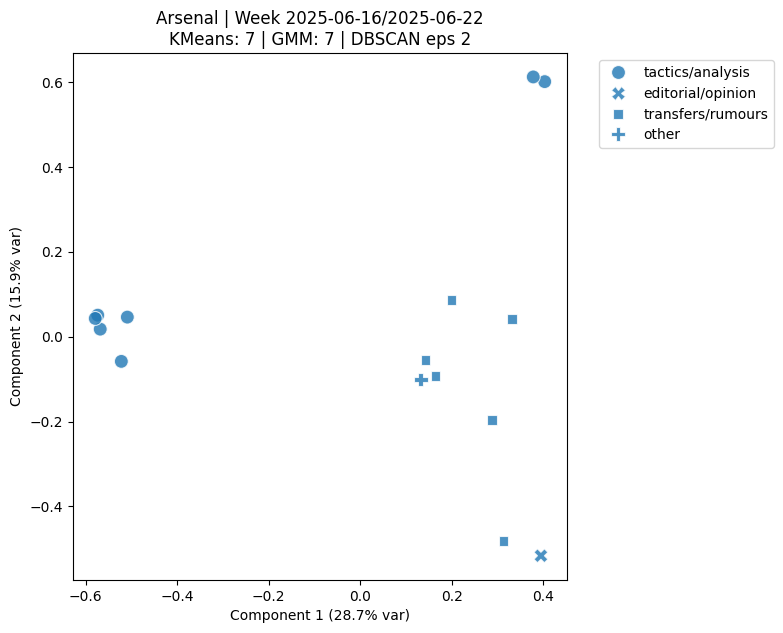

Team: Arsenal; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


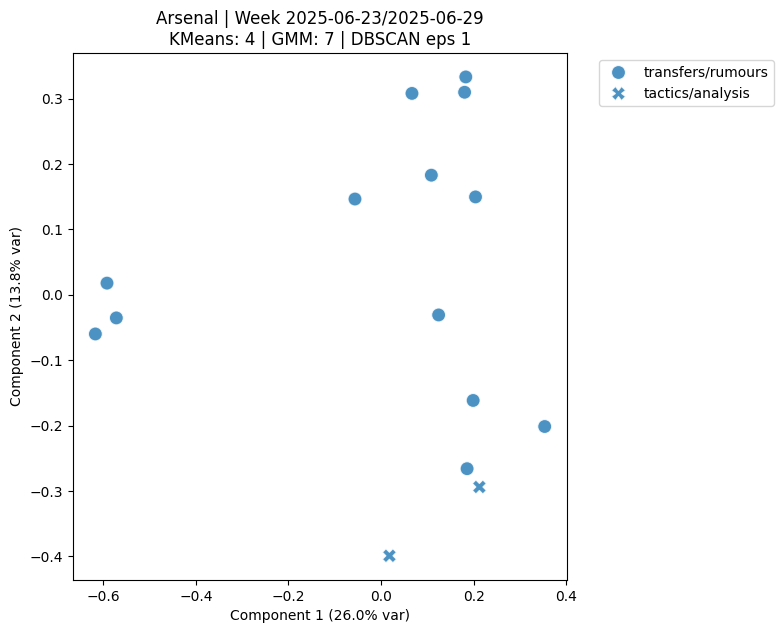

Team: Arsenal; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


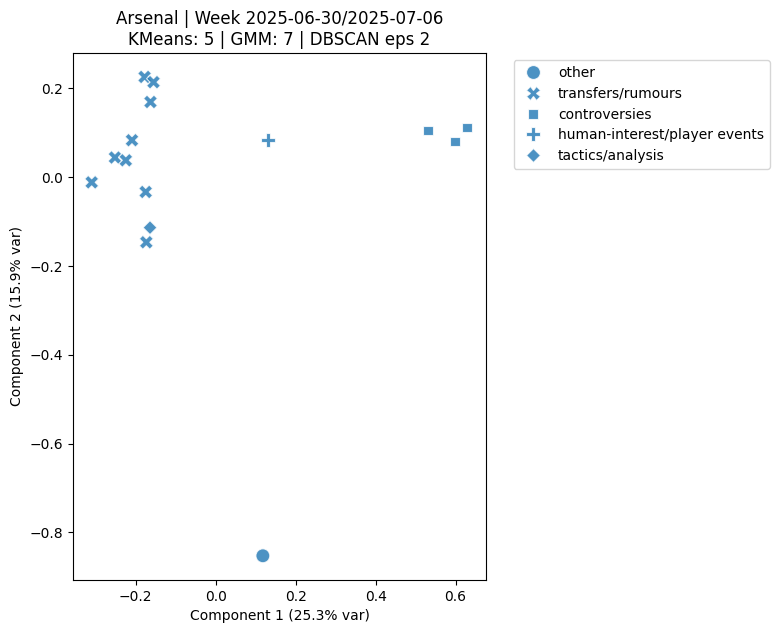

Team: Arsenal; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


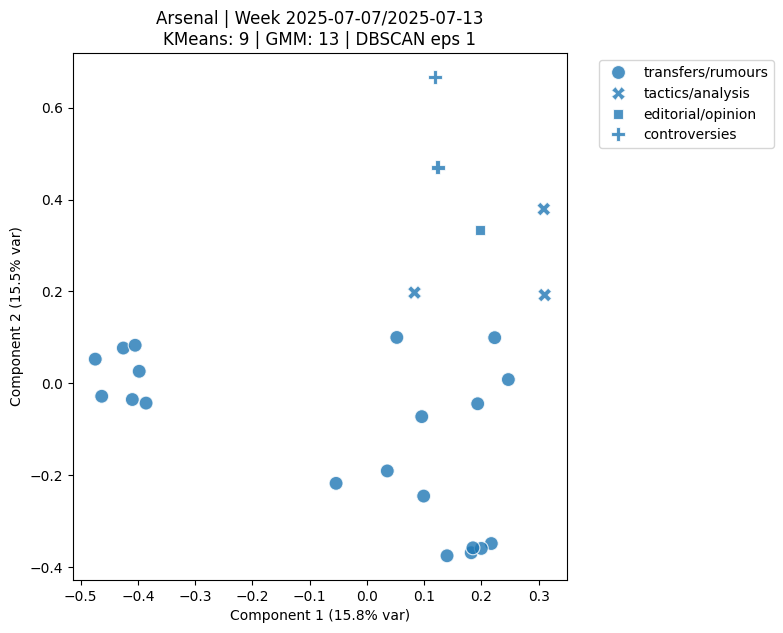

Team: Arsenal; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


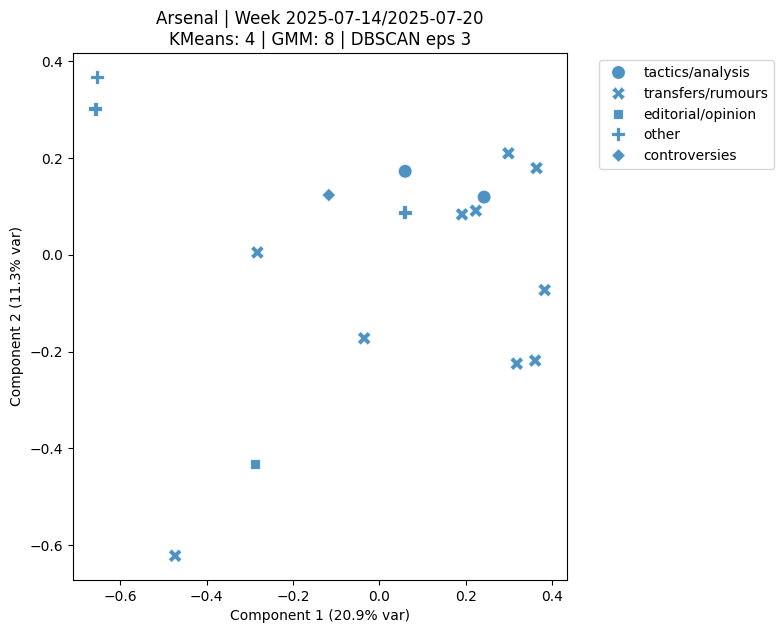

Team: Arsenal; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


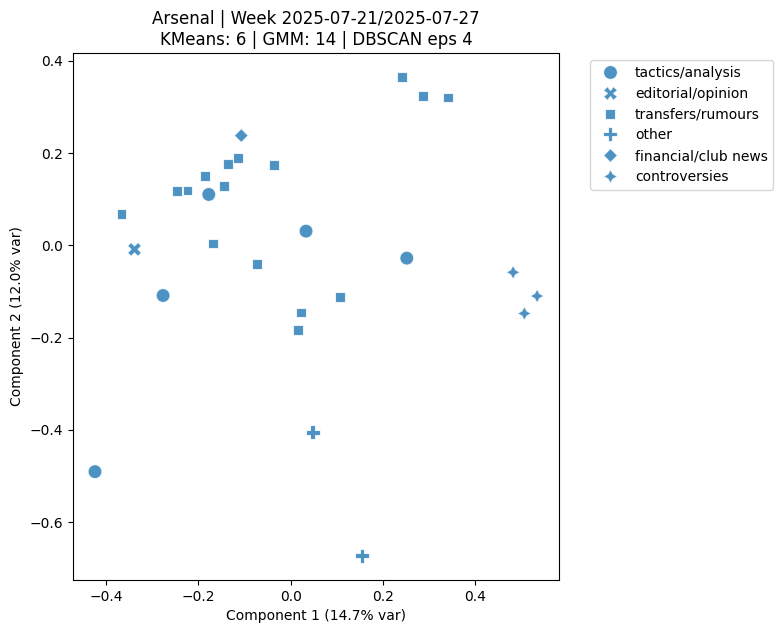

Team: Arsenal; Week 2025-07-28/2025-08-03



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


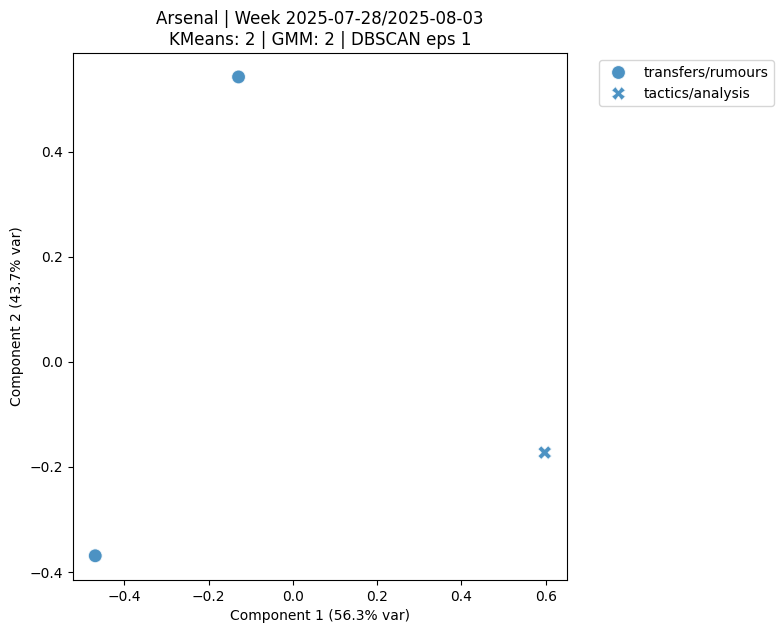

Team: Chelsea; Week 2024-08-19/2024-08-25

Not enough articles to cluster.
Team: Chelsea; Week 2025-05-26/2025-06-01

Not enough articles to cluster.
Team: Chelsea; Week 2025-06-09/2025-06-15



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


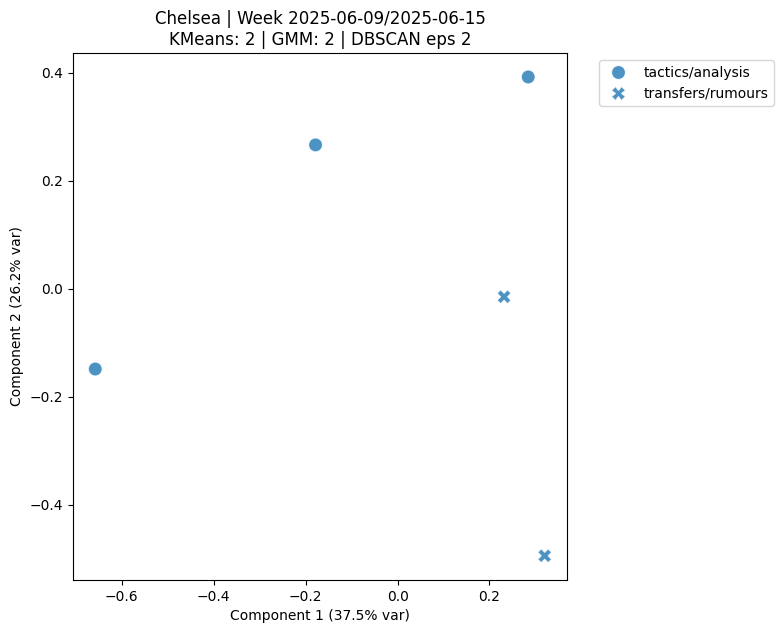

Team: Chelsea; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


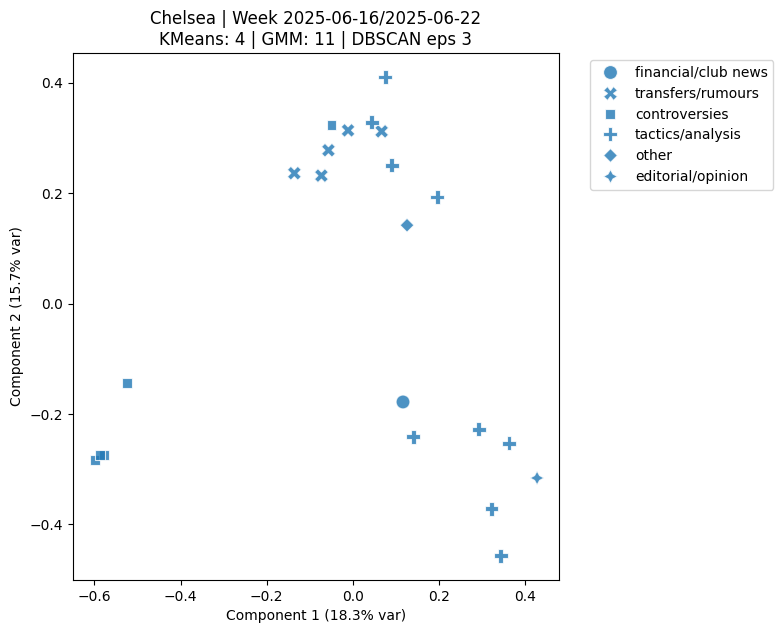

Team: Chelsea; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


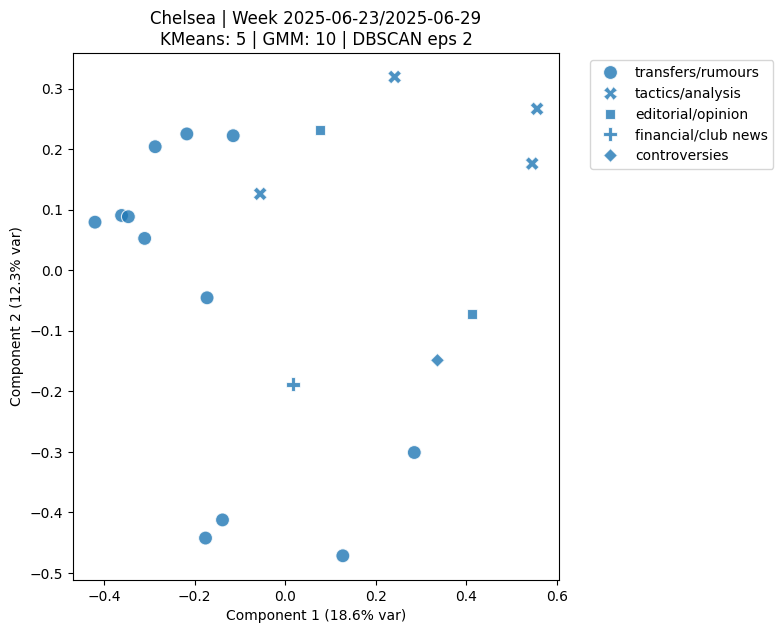

Team: Chelsea; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


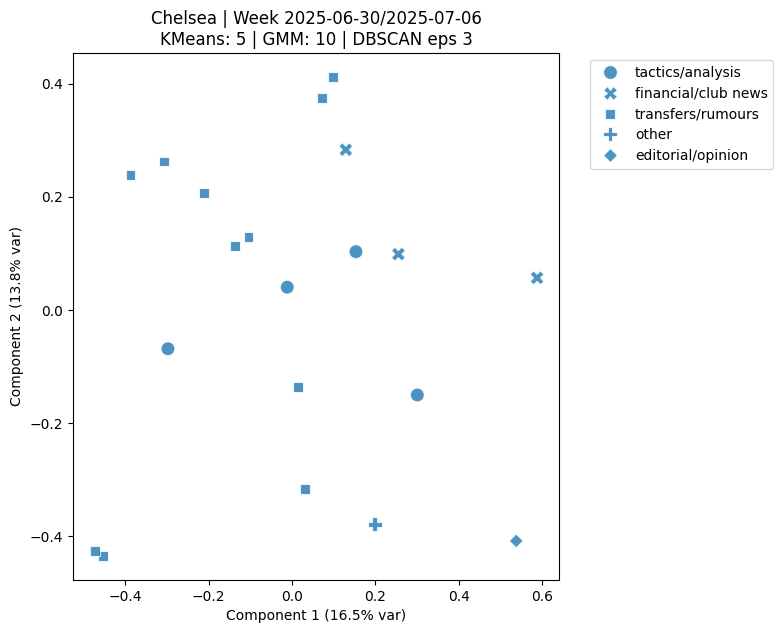

Team: Chelsea; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


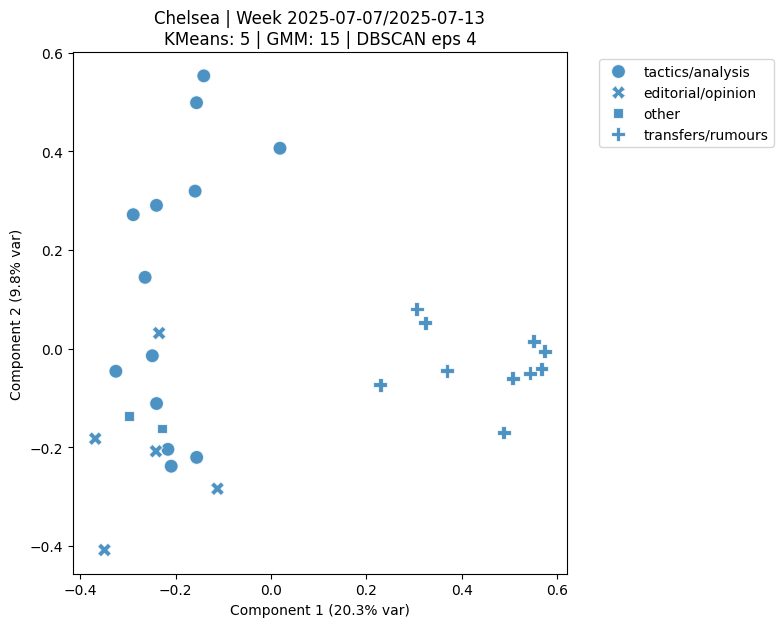

Team: Chelsea; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


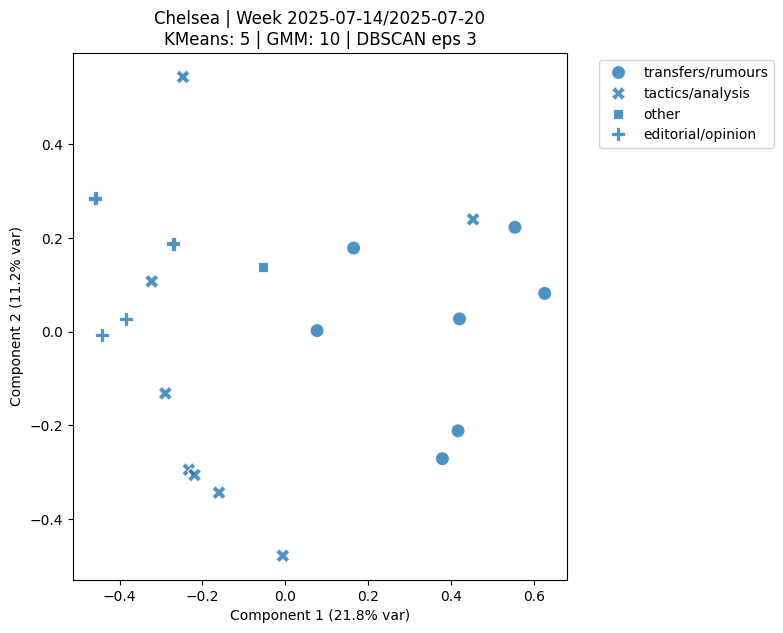

Team: Chelsea; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


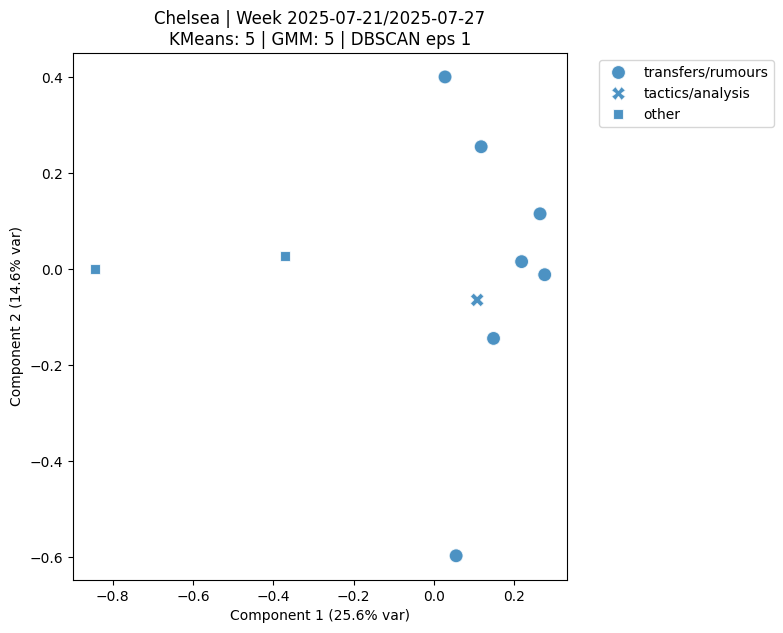

Team: Chelsea; Week 2025-07-28/2025-08-03

Not enough articles to cluster.
Team: Liverpool; Week 2025-05-26/2025-06-01

Not enough articles to cluster.
Team: Liverpool; Week 2025-06-09/2025-06-15



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


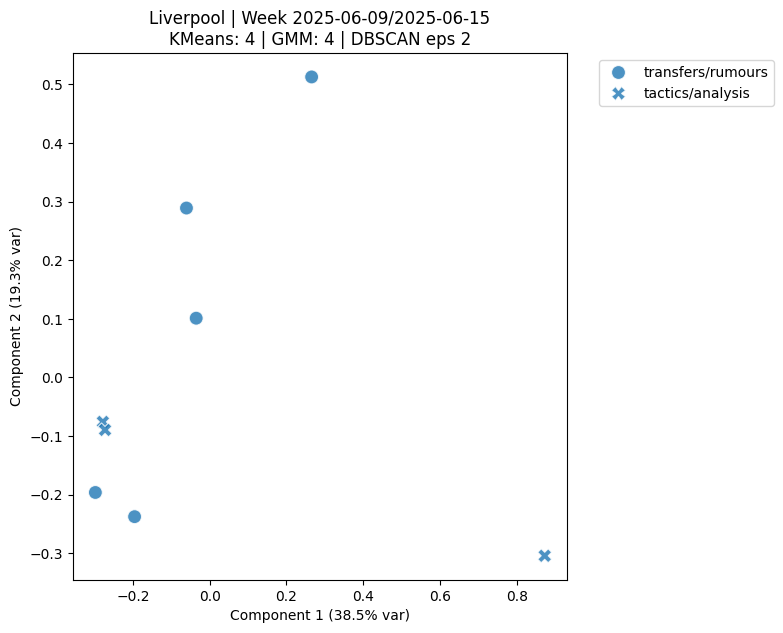

Team: Liverpool; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


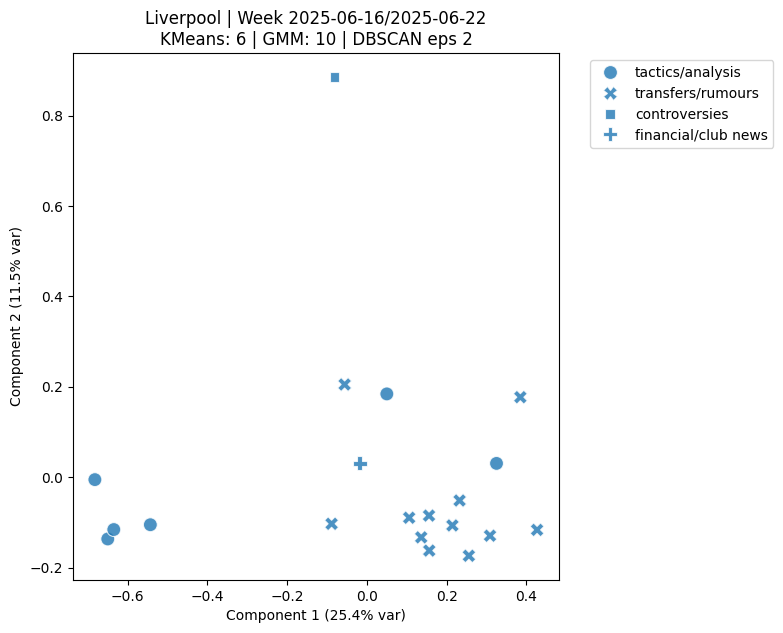

Team: Liverpool; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


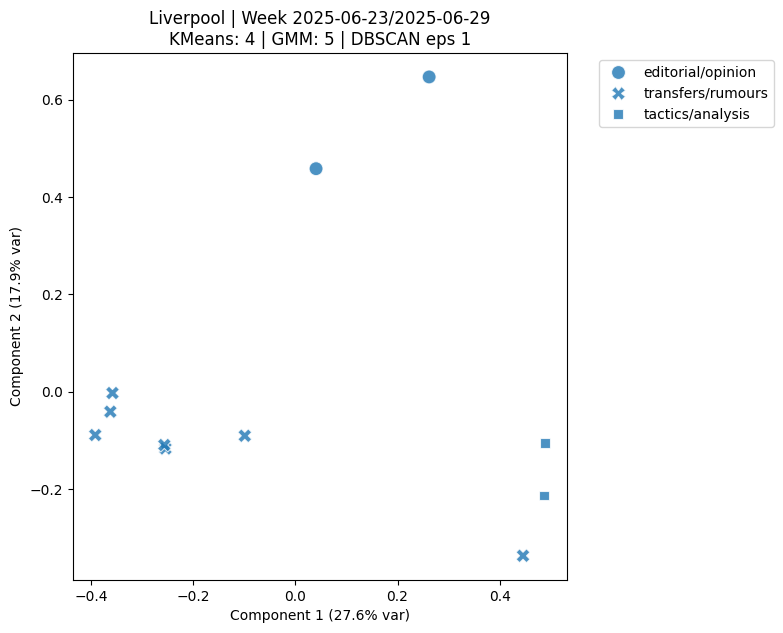

Team: Liverpool; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


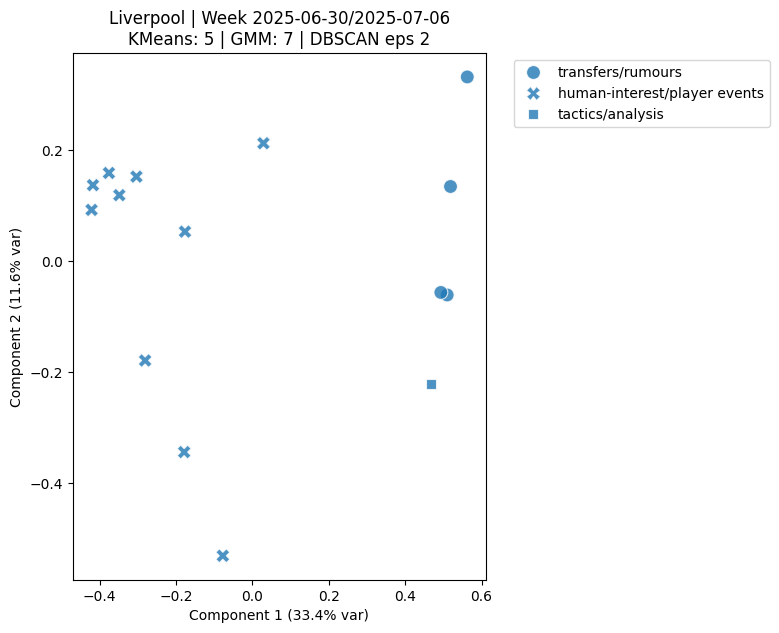

Team: Liverpool; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


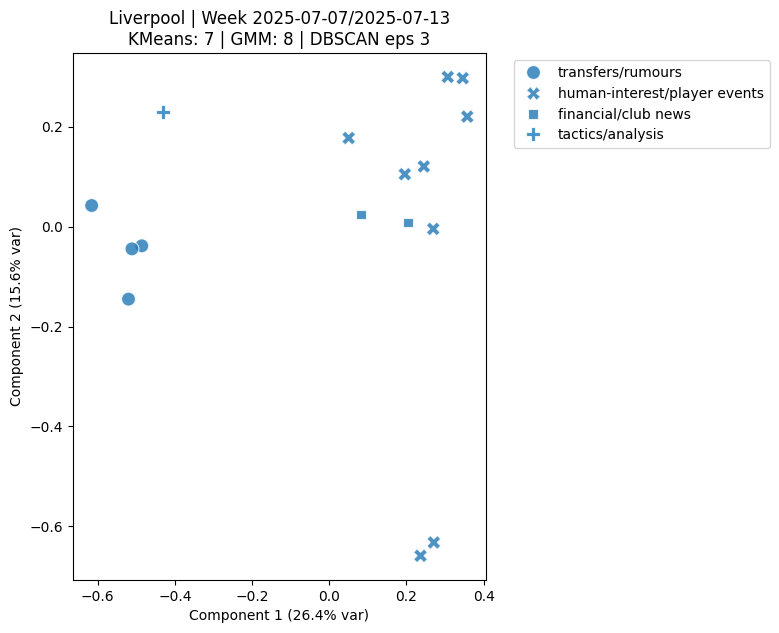

Team: Liverpool; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


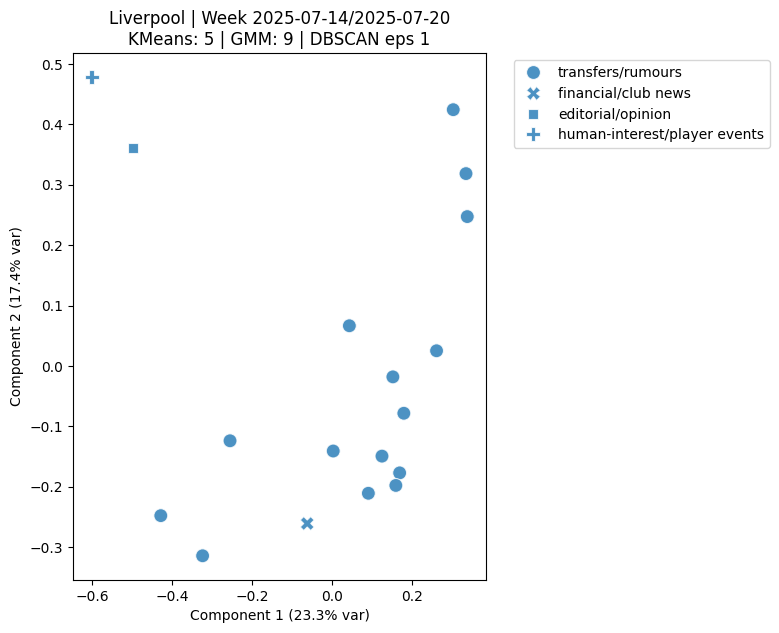

Team: Liverpool; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


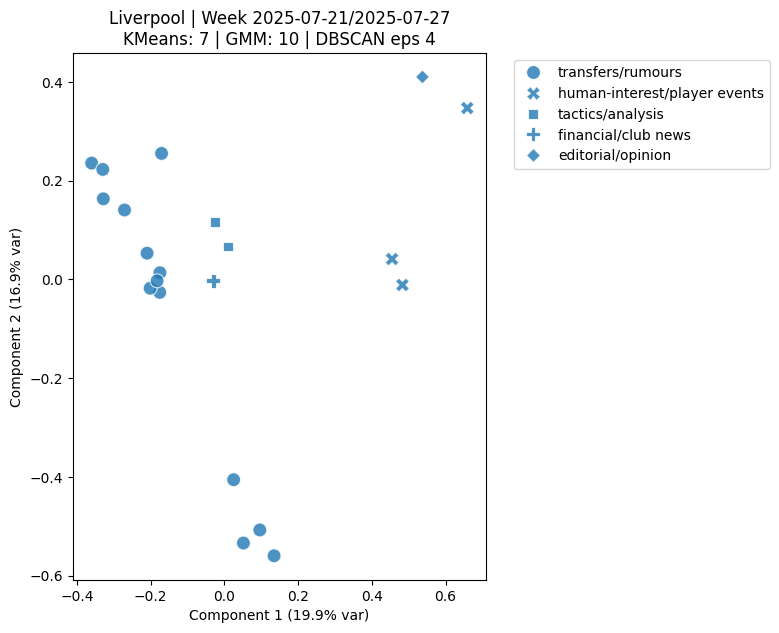

Team: Liverpool; Week 2025-07-28/2025-08-03



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


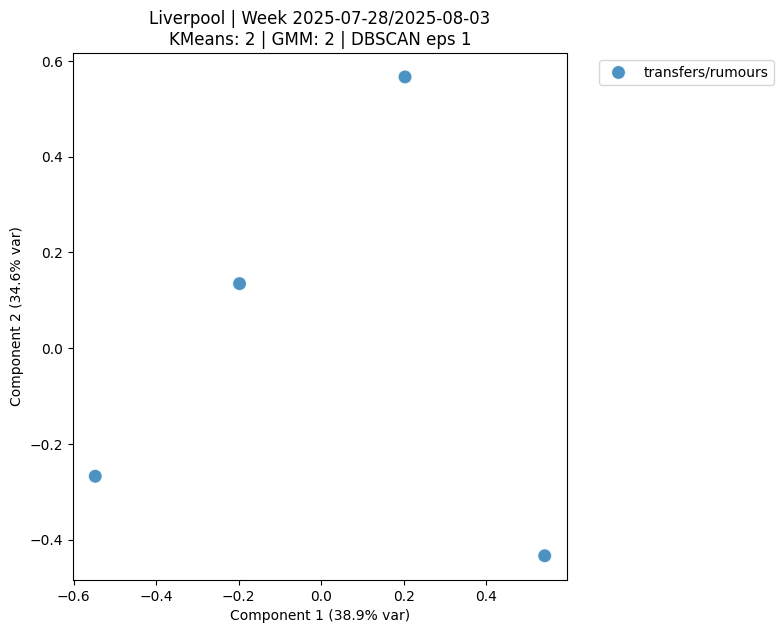

Team: Manchester City; Week 2025-06-02/2025-06-08

Not enough articles to cluster.
Team: Manchester City; Week 2025-06-09/2025-06-15



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


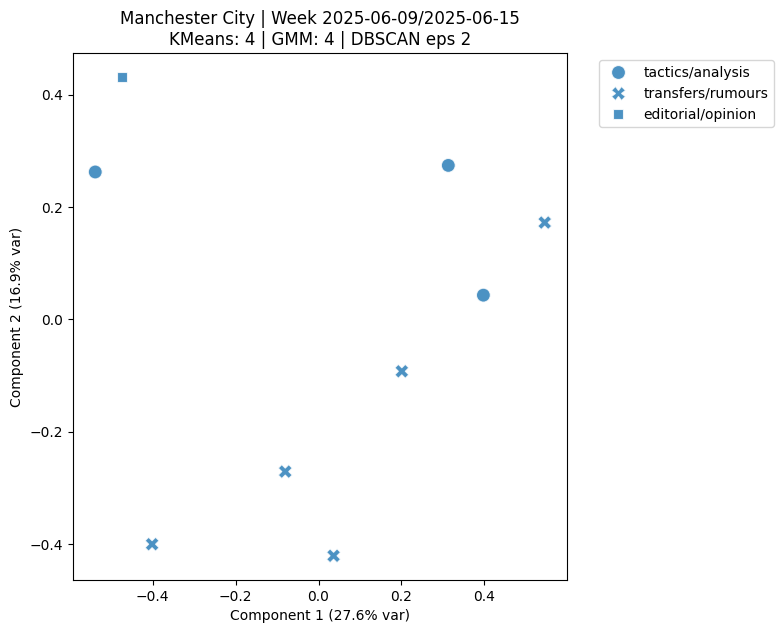

Team: Manchester City; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


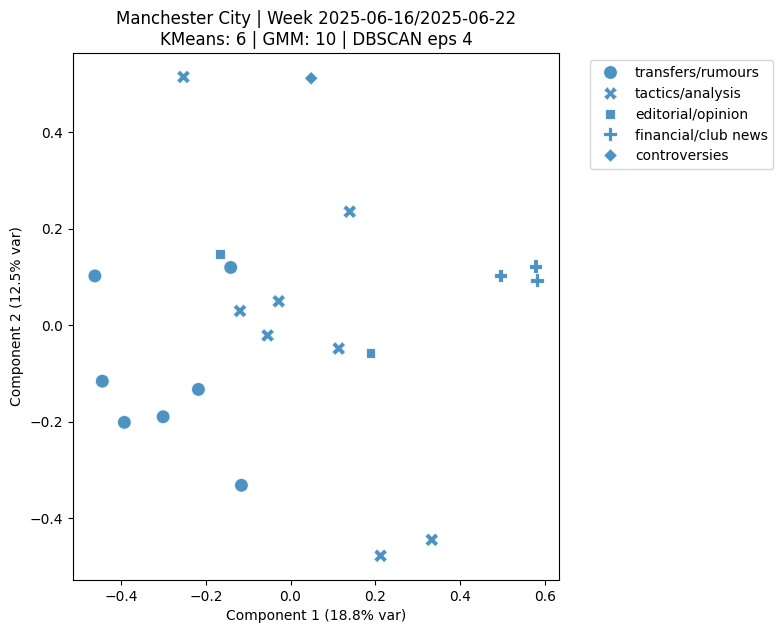

Team: Manchester City; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


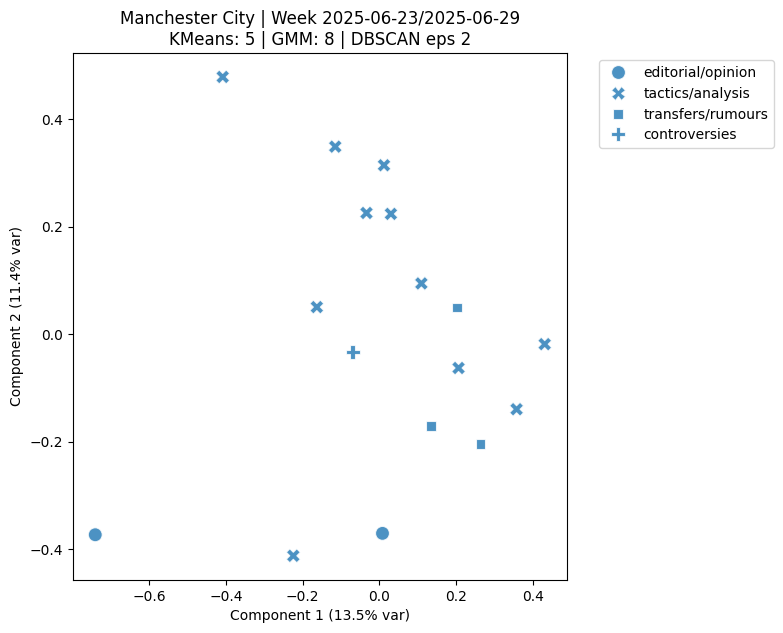

Team: Manchester City; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


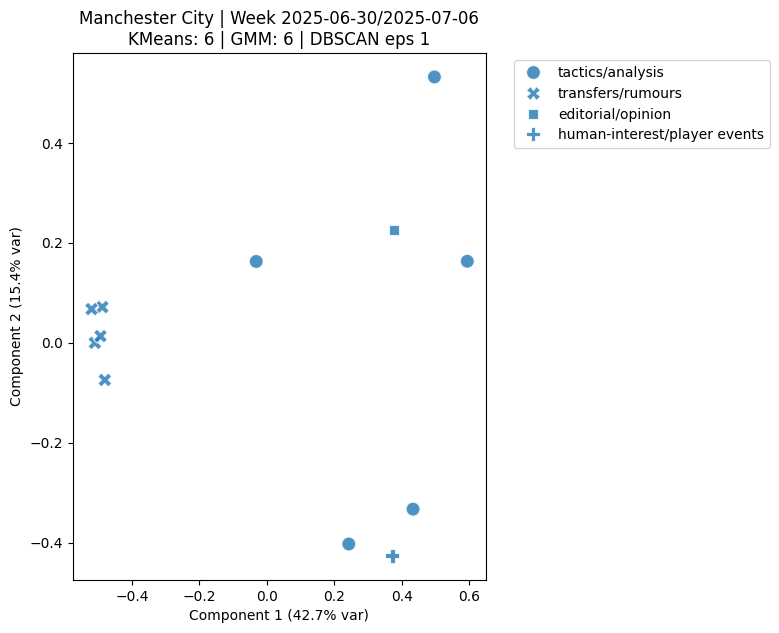

Team: Manchester City; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


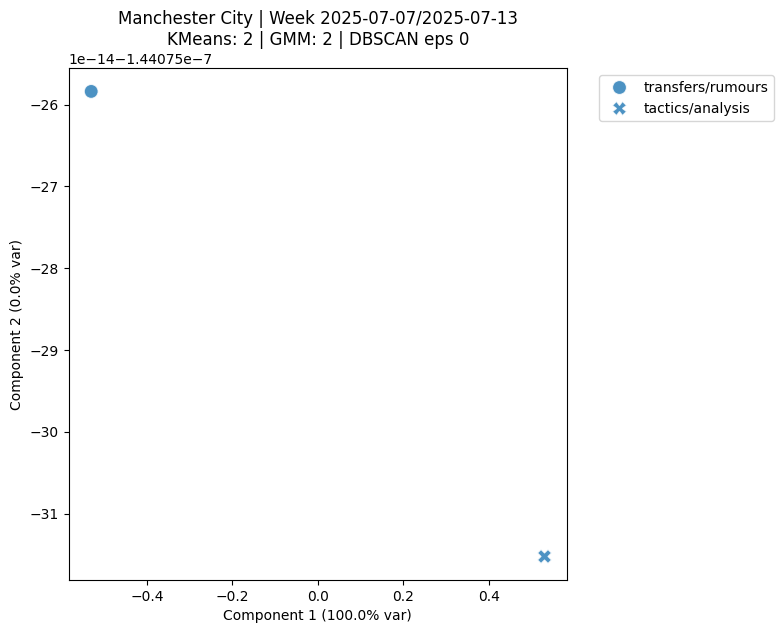

Team: Manchester City; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


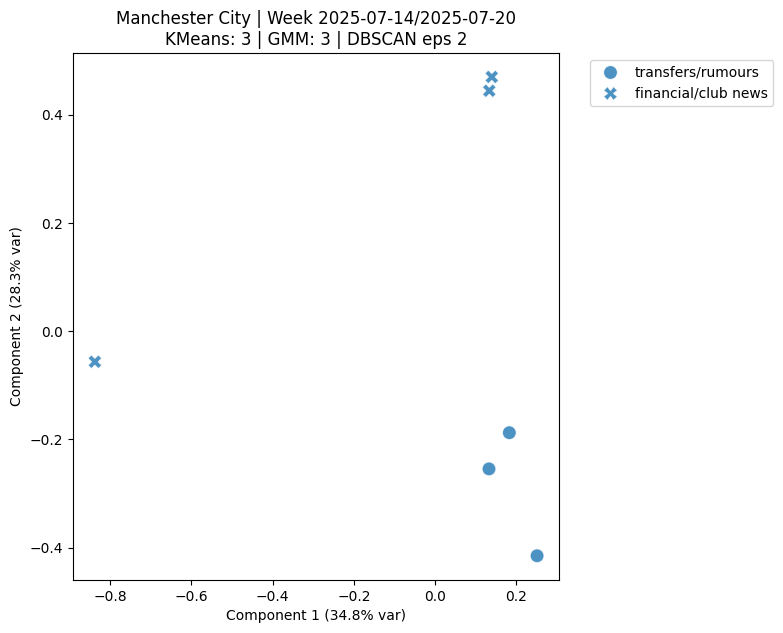

Team: Manchester City; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


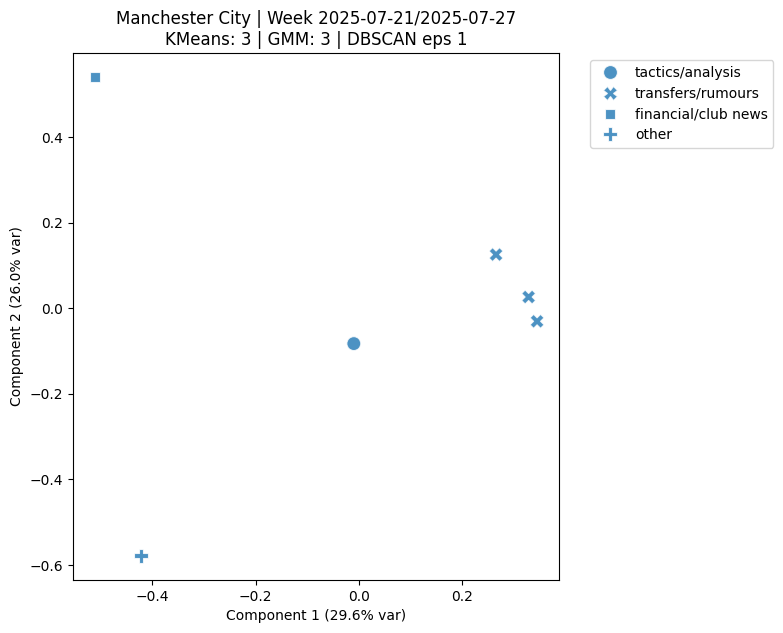

Team: Manchester City; Week 2025-07-28/2025-08-03



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


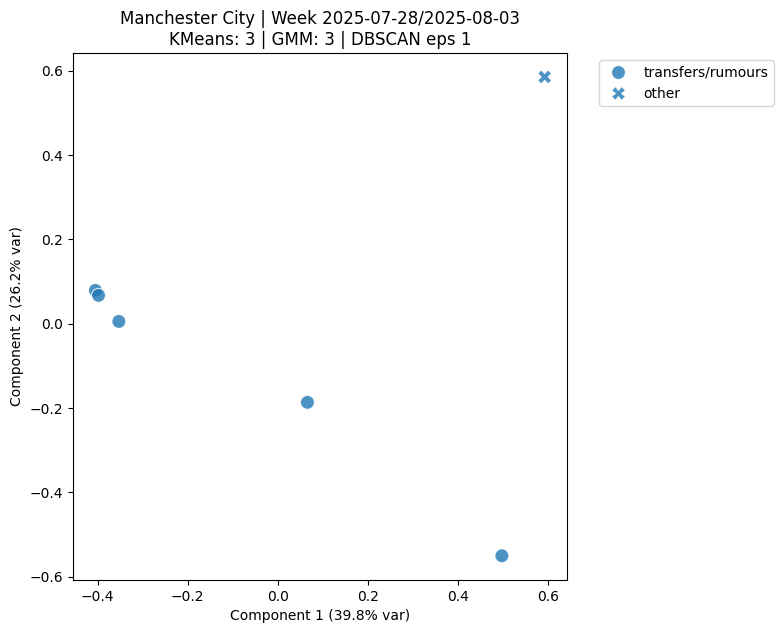

Team: Manchester United; Week 2025-05-26/2025-06-01

Not enough articles to cluster.
Team: Manchester United; Week 2025-06-02/2025-06-08



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


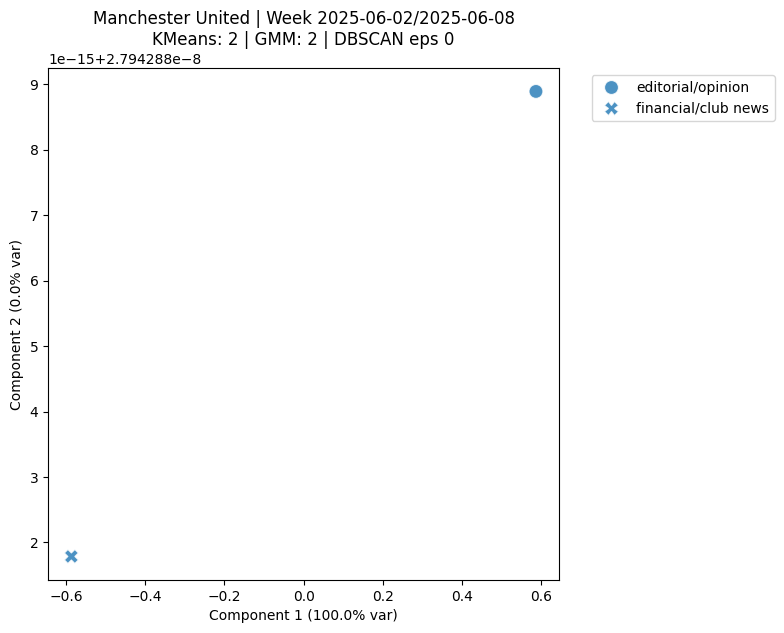

Team: Manchester United; Week 2025-06-09/2025-06-15



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


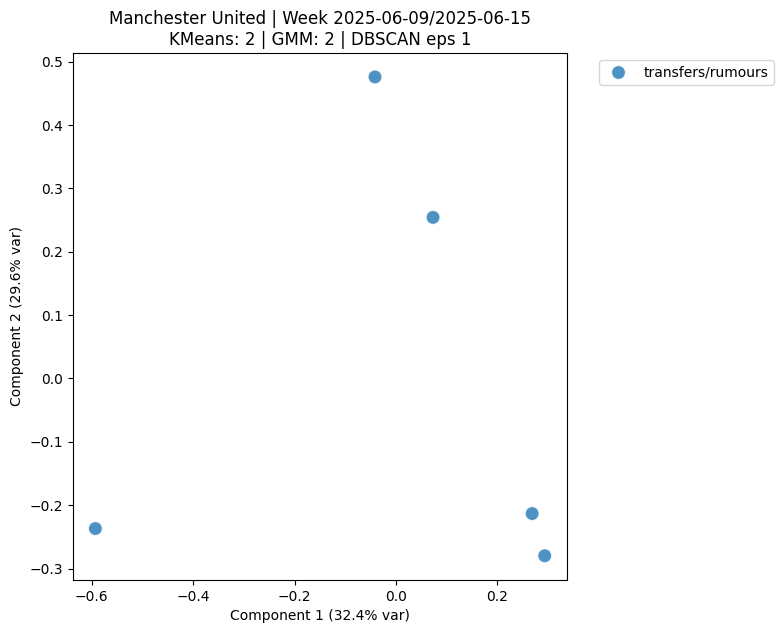

Team: Manchester United; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


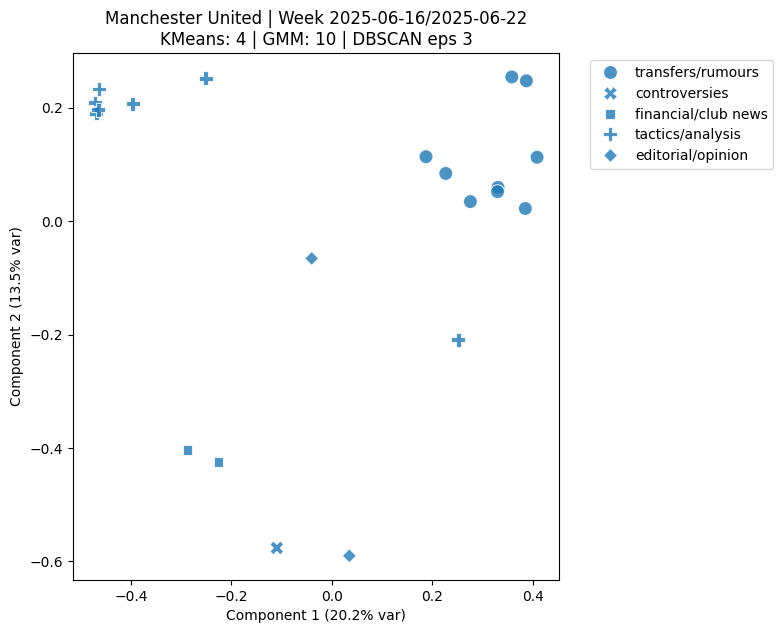

Team: Manchester United; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


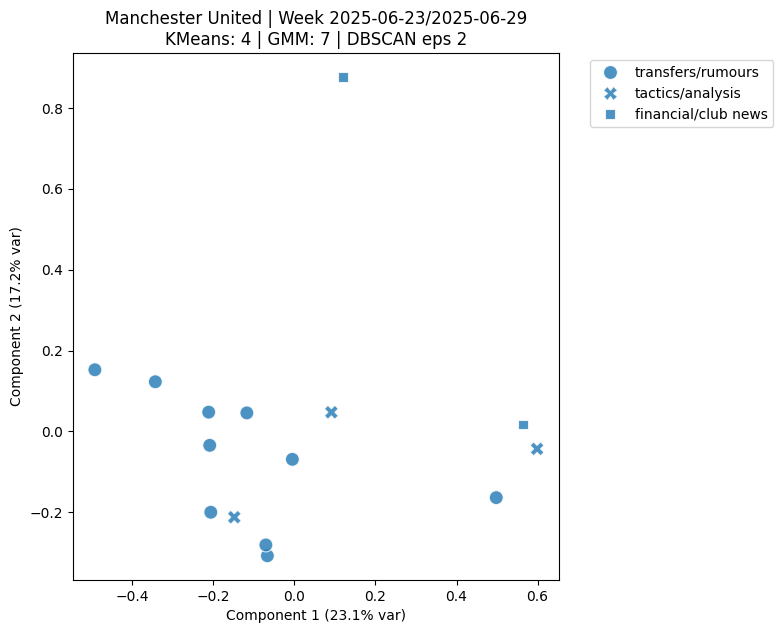

Team: Manchester United; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


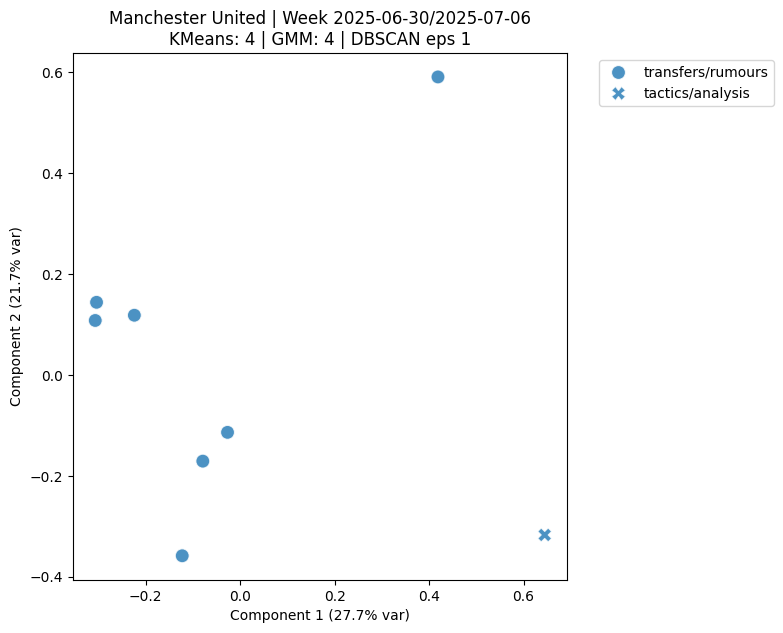

Team: Manchester United; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


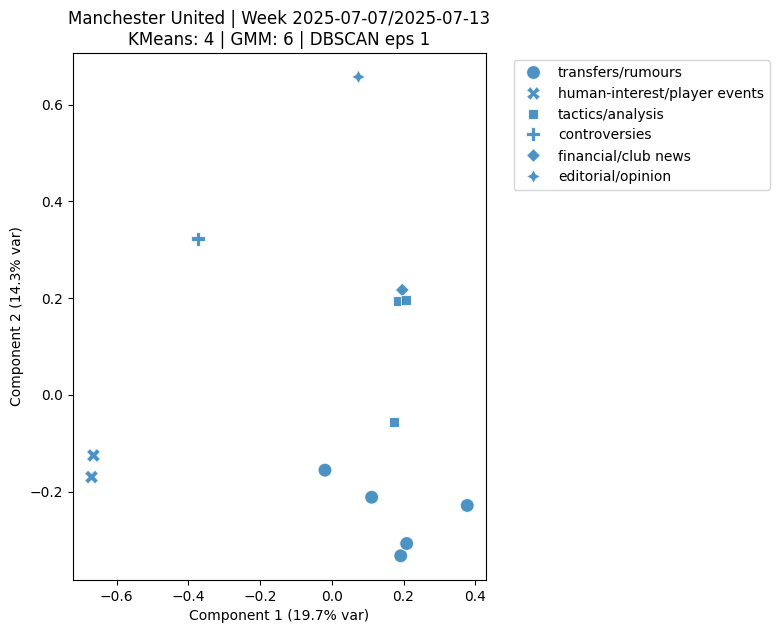

Team: Manchester United; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


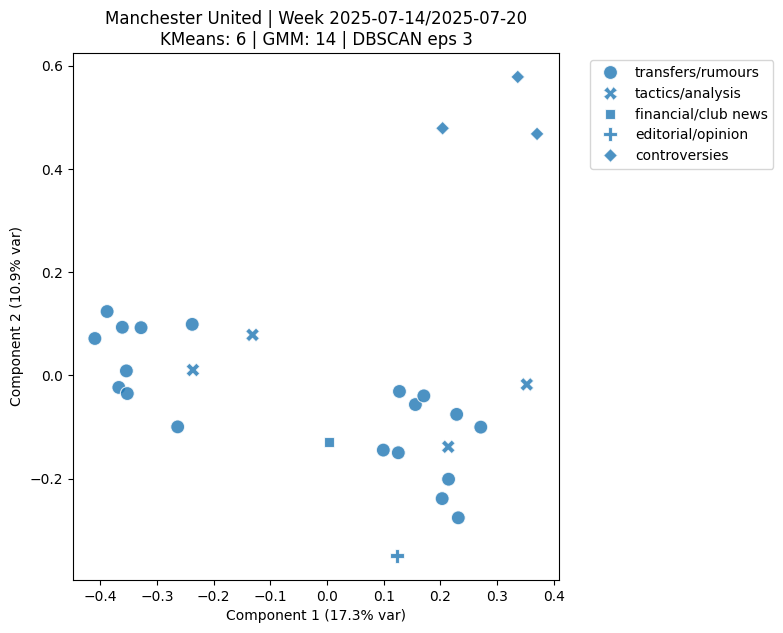

Team: Manchester United; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


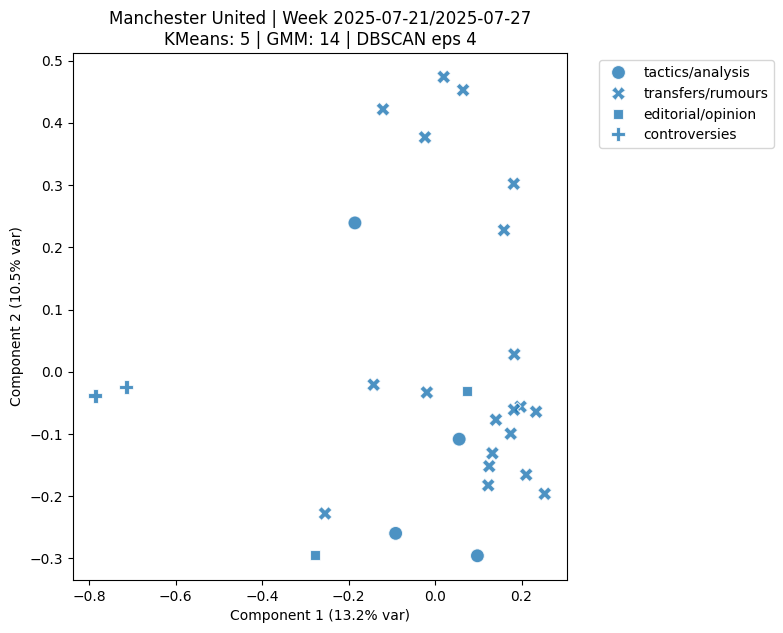

Team: Manchester United; Week 2025-07-28/2025-08-03



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


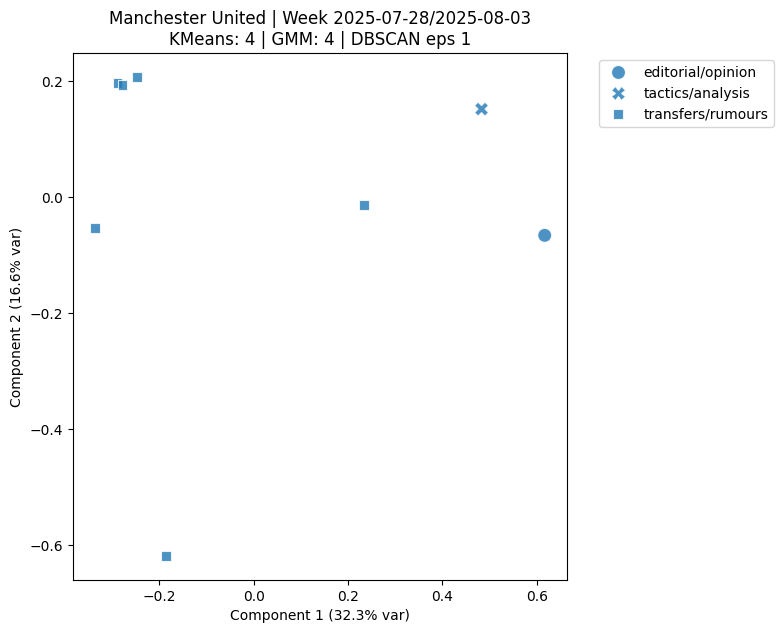

Team: Tottenham Hotspur; Week 2025-02-10/2025-02-16

Not enough articles to cluster.
Team: Tottenham Hotspur; Week 2025-06-02/2025-06-08



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


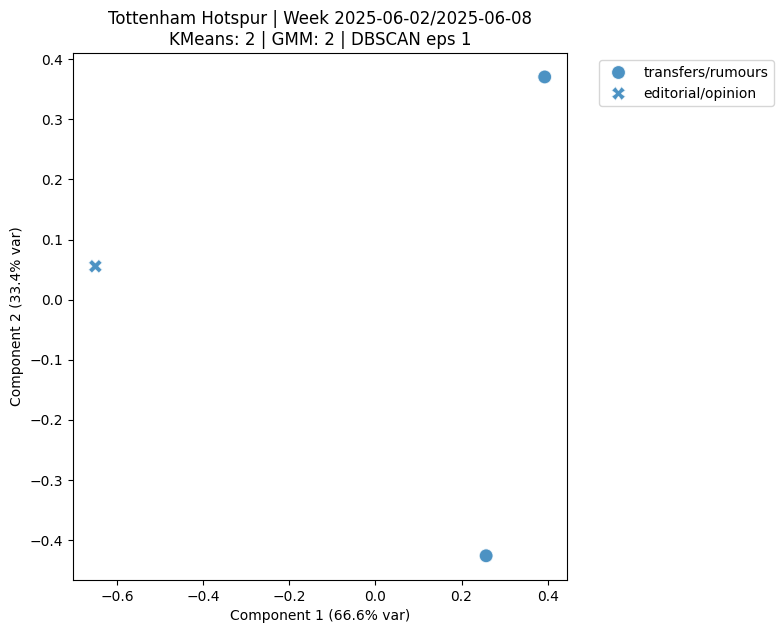

Team: Tottenham Hotspur; Week 2025-06-09/2025-06-15



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


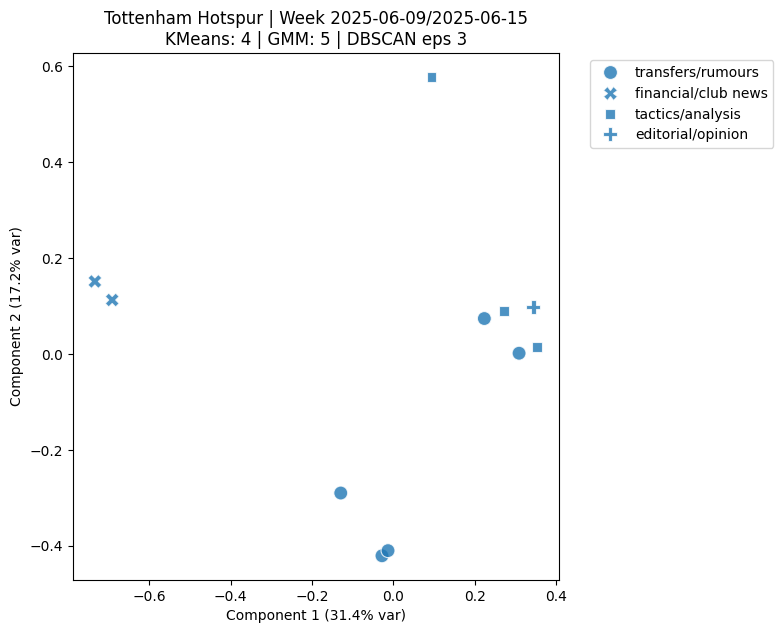

Team: Tottenham Hotspur; Week 2025-06-16/2025-06-22



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


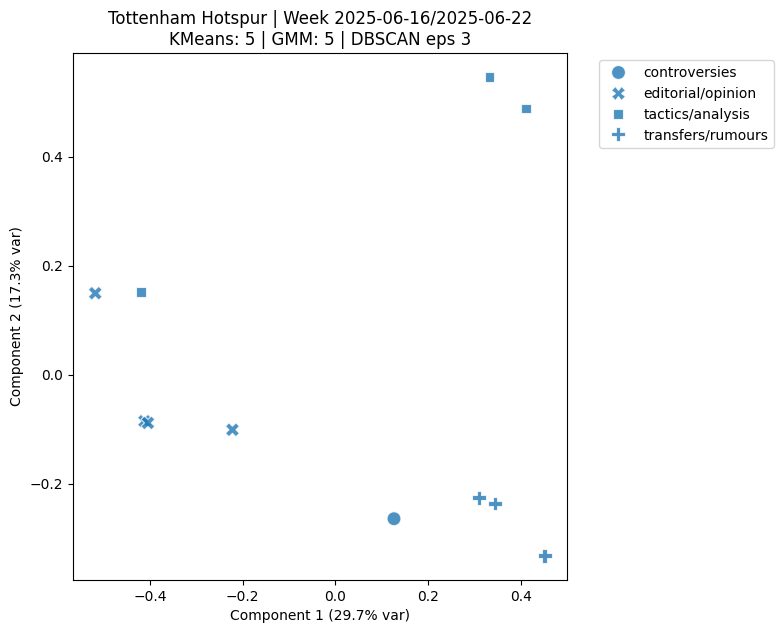

Team: Tottenham Hotspur; Week 2025-06-23/2025-06-29



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


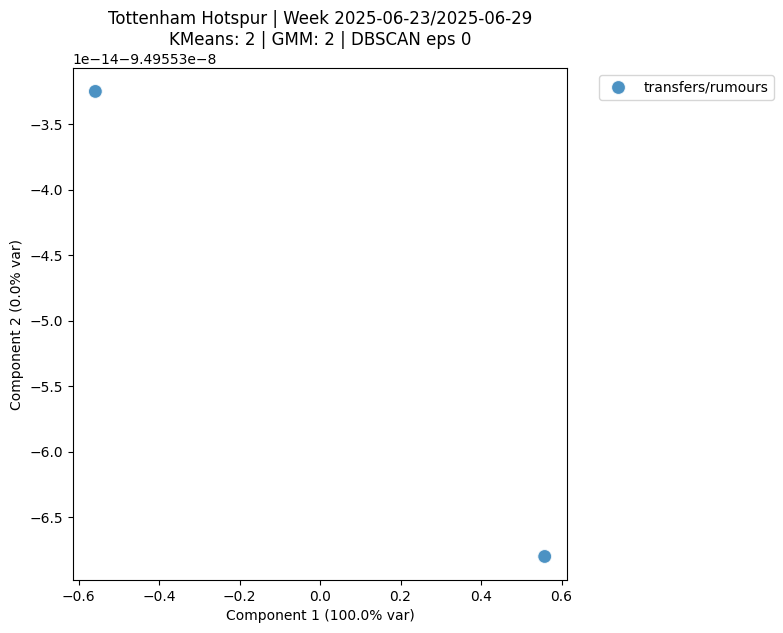

Team: Tottenham Hotspur; Week 2025-06-30/2025-07-06



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


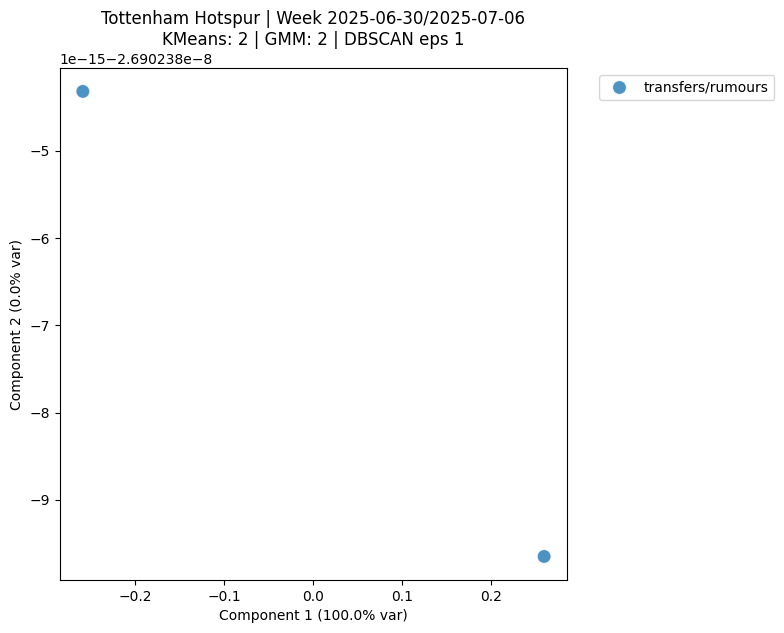

Team: Tottenham Hotspur; Week 2025-07-07/2025-07-13



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


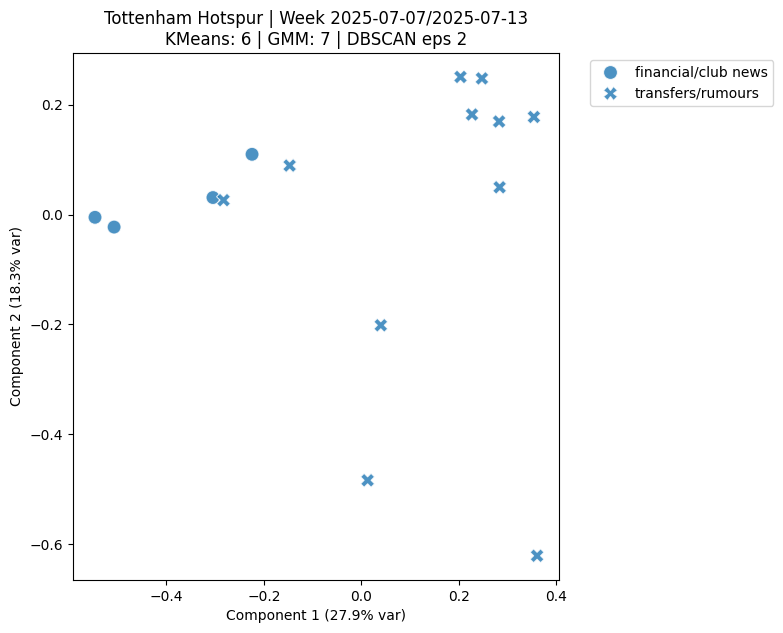

Team: Tottenham Hotspur; Week 2025-07-14/2025-07-20



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


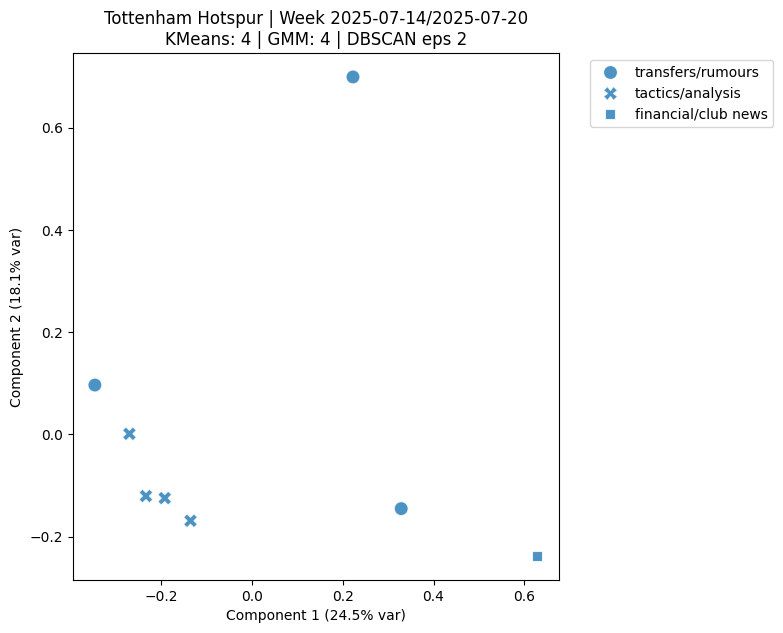

Team: Tottenham Hotspur; Week 2025-07-21/2025-07-27



Batches:   0%|          | 0/1 [00:00<?, ?it/s]

C:\Users\javie\AppData\Local\Temp\ipykernel_1800\277886143.py:68: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


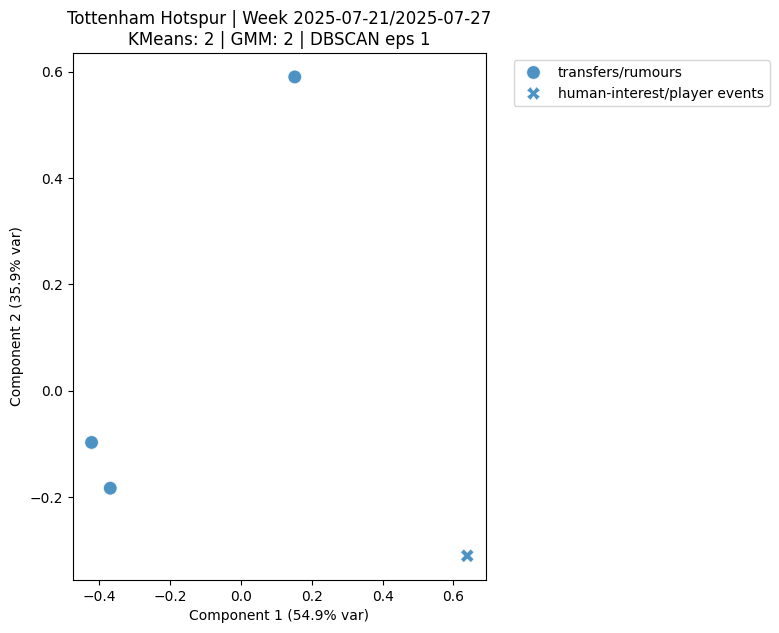

Team: Tottenham Hotspur; Week 2025-07-28/2025-08-03

Not enough articles to cluster.


In [ ]:
# Load the one-hot encoder and PCA
enc = OneHotEncoder(handle_unknown='ignore')
pca = PCA(n_components=2)

# Iterate through each team and week to perform clustering
for (team, week), group in articles_df.groupby(["Team", "Week"]):
    # Check if there are enough articles to cluster
    n_articles = group["Article_ID"].nunique()
    if n_articles < 2: 
        print("Not enough articles to cluster.")
        continue

    # Embed the full text and one-hot encode the topics to create the feature matri
    X_emb = sbert.encode(group["Full_text"].tolist(), show_progress_bar=True)
    topic_encoded = enc.fit_transform(group[["Topic"]]).toarray()
    X = np.concatenate((X_emb, topic_encoded), axis=1)

    # Putting a lower and upper bound on k
    lower_bound = 2
    upper_bound = max(lower_bound, n_articles // 2)
    k = range(lower_bound, min(upper_bound, n_articles) + 1)

    # Perform KMeans and GMM clustering
    inertias = []
    bic = []
    for n_clusters in k: 
        km = KMeans(n_clusters=n_clusters, random_state=42)
        km.fit(X)
        inertias.append(km.inertia_)

        gmm = GaussianMixture(n_components=n_clusters, covariance_type="full", random_state=42)
        gmm.fit(X)
        bic.append(gmm.bic(X))

    # Calculate the optimal k for KMeans and fit the model
    optimal_k = lower_bound + calculate_distance(inertias)   
    km = KMeans(n_clusters=optimal_k, random_state=42)
    km_labels = km.fit_predict(X)

    # Calculate the optimal k for GMM and fit the model
    gmm_k = lower_bound + max(range(len(bic)), key=bic.__getitem__)
    gmm = GaussianMixture(n_components=gmm_k, covariance_type="full", random_state=42)
    gmm_labels = gmm.fit_predict(X)

    # Calculate the optimal eps for DBSCAN and fit the model
    optimal_eps = find_optimal_eps(X)
    dbscan = DBSCAN(eps=optimal_eps, min_samples=2)
    dbscan_labels = dbscan.fit_predict(X)

    # Store the clustering results in the articles_df
    articles_df.loc[group.index, "kmeans"] = km_labels
    articles_df.loc[group.index, "dbscan"] = dbscan_labels
    articles_df.loc[group.index, "gmm"] = gmm_labels
    
    # Use a color palette for the teams
    palette = sns.color_palette("tab10", n_colors=6)  # 6 teams

    # Use PCA to reduce the dimensionality of the embeddings for the plot
    comps = pca.fit_transform(X_emb)
    df = group.copy()
    df["PC1"], df["PC2"] = comps[:, 0], comps[:, 1]
    df["Topic_Label"] = df["Topic"].map(TOPICS_MAPPING)

    # Use seaborn to create a scatterplot of the PCA components
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x="PC1", y="PC2",
        palette=palette,
        style="Topic_Label",  # use mapped topic labels for the shape
        s=100,                        
        edgecolor="w",
        alpha=0.8
    )

    # Add titles and labels
    plt.xlabel(f"Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)") 
    plt.ylabel(f"Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.title(f"{team} | Week {week}\nKMeans: {optimal_k} | GMM: {gmm_k} | DBSCAN: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
    plt.show()

Now we analyze the clustering results of each algorithm. 

In [ ]:
# Display the k-means clusters for each team and week
for (team, week), group in articles_df.groupby(["Team", "Week"]):
    print(f"Team: {team}; Week {week}\n")
    clusters = sorted(group["kmeans"].unique())

    # Get the title of each article and the cluster it belongs to
    for cluster in clusters:
        titles = group.loc[group["kmeans"] == cluster, "Title"].tolist()
        for title in titles: 
            print(f"Cluster {cluster}: {title}")
        
        print("")

Team: Arsenal; Week 2025-06-16/2025-06-22

Cluster 0.0: England's Lewis-Skelly agrees new Arsenal contract
Cluster 0.0: Partey’s contract talks with Arsenal hit impasse but Lewis-Skelly poised to si
Cluster 0.0: Mikel Arteta poised to lose key Arsenal assistant Carlos Cuesta to Parma
Cluster 0.0: Football transfer rumours: Jack Grealish to join McTominay at Napoli?

Cluster 1.0: Premier League fixtures: Man Utd host Arsenal on bumper opening weekend
Cluster 1.0: Arsenal fixtures: Gunners face nightmare start with trips to Old Trafford and Anfield
Cluster 1.0: Man Utd fixtures: United start at home to Arsenal on Sky in tough opening run
Cluster 1.0: Tottenham fixtures: Frank's first PL game in charge against Burnley at home
Cluster 1.0: Premier League opening fixtures: Liverpool host Bournemouth, Arsenal at Manchester United

Cluster 2.0: Santi Cazorla scores in playoff as Real Oviedo end 24-year wait for La Liga return
Cluster 2.0: Cazorla, 40, scores as Oviedo return to La Liga

Clust

In [ ]:
# Display the dbscan clusters for each team and week
for (team, week), group in articles_df.groupby(["Team", "Week"]):
    print(f"Team: {team}; Week {week}\n")
    clusters = sorted(group["dbscan"].unique())

    # Get the title of each article and the cluster it belongs to
    for cluster in clusters:
        titles = group.loc[group["dbscan"] == cluster, "Title"].tolist()
        for title in titles: 
            print(f"Cluster {cluster}: {title}")
        
        print("")

Team: Arsenal; Week 2025-06-16/2025-06-22

Cluster -1.0: It can be a really lonely journey: Myles Lewis-Skellys mum Marcia on being a stars parent and agent
Cluster -1.0: Chloe Kelly focused on Lionesses despite talk of Arsenal targeting permanent move

Cluster 0.0: Santi Cazorla scores in playoff as Real Oviedo end 24-year wait for La Liga return
Cluster 0.0: Cazorla, 40, scores as Oviedo return to La Liga
Cluster 0.0: Premier League fixtures: Man Utd host Arsenal on bumper opening weekend
Cluster 0.0: Arsenal fixtures: Gunners face nightmare start with trips to Old Trafford and Anfield
Cluster 0.0: Man Utd fixtures: United start at home to Arsenal on Sky in tough opening run
Cluster 0.0: Tottenham fixtures: Frank's first PL game in charge against Burnley at home
Cluster 0.0: Premier League opening fixtures: Liverpool host Bournemouth, Arsenal at Manchester United

Cluster 1.0: England's Lewis-Skelly agrees new Arsenal contract
Cluster 1.0: Why Hugo Ekitike is hot property in the 

In [ ]:
# Display the gmm clusters for each team and week
for (team, week), group in articles_df.groupby(["Team", "Week"]):
    print(f"Team: {team}; Week {week}\n")
    clusters = sorted(group["gmm"].unique())

    # Get the title of each article and the cluster it belongs to
    for cluster in clusters:
        titles = group.loc[group["gmm"] == cluster, "Title"].tolist()
        for title in titles: 
            print(f"Cluster {cluster}: {title}")
        
        print("")

Team: Arsenal; Week 2025-06-16/2025-06-22

Cluster 0.0: England's Lewis-Skelly agrees new Arsenal contract
Cluster 0.0: Partey’s contract talks with Arsenal hit impasse but Lewis-Skelly poised to si
Cluster 0.0: Mikel Arteta poised to lose key Arsenal assistant Carlos Cuesta to Parma
Cluster 0.0: Football transfer rumours: Jack Grealish to join McTominay at Napoli?

Cluster 1.0: Premier League fixtures: Man Utd host Arsenal on bumper opening weekend
Cluster 1.0: Arsenal fixtures: Gunners face nightmare start with trips to Old Trafford and Anfield
Cluster 1.0: Man Utd fixtures: United start at home to Arsenal on Sky in tough opening run
Cluster 1.0: Tottenham fixtures: Frank's first PL game in charge against Burnley at home
Cluster 1.0: Premier League opening fixtures: Liverpool host Bournemouth, Arsenal at Manchester United

Cluster 2.0: Santi Cazorla scores in playoff as Real Oviedo end 24-year wait for La Liga return
Cluster 2.0: Cazorla, 40, scores as Oviedo return to La Liga

Clust

We observe that the GMM gets too many clusters, making it difficult to summarize what has happened in a week, since there are many clusters with just an article. On the other hand, DBSCAN usually does a good job when there are many articles, but struggles when there are not too many articles in that week, therefore creating too few clusters and merging news that are not related. Finally, k-means provides a balance between both models, having not too many but not too few clusters, with them being meaningful, although sometimes some articles get into a cluster they shouldn't it is not a huge issue and was expected. 

Therefefore, we will use k-means as our clustering algorithm, with the distance-to-line method to choose the number of clusters.

In [9]:
articles_df["Weekly_Cluster"] = articles_df["kmeans"]
articles_df.drop(columns=["kmeans", "dbscan", "gmm"], inplace=True)

In [20]:


# 1) your topic→marker mapping
TOPICS_MAPPING = {
    0: "transfers/rumours",
    1: "financial/club news",
    2: "controversies",
    3: "tactics/analysis",
    4: "editorial/opinion",
    5: "human-interest/player events",
    6: "other"
}


for (team, week), group in articles_df.groupby(["Team", "Week"]):
    if group["Article_ID"].nunique() < 2:
        print(f"{team} | {week}: Not enough articles.")
        continue

    # 2) embed + PCA
    X_emb = sbert.encode(group["Full_text"].tolist(), show_progress_bar=True)
    comps = pca.fit_transform(X_emb)
    df = group.copy()
    df["PC1"], df["PC2"] = comps[:, 0], comps[:, 1]

    # 3) choose a discrete palette with as many colors as you have clusters
    n_clusters = df["Weekly_Cluster"].nunique()
    palette = sns.color_palette("tab10", n_colors=n_clusters)

    # 4) single call to seaborn.scatterplot
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x="PC1", y="PC2",
        hue="Weekly_Cluster",          # continuous → discrete legend automatically
        palette=palette,
        style="Topic",                 # integer codes map to your markers below
        s=100,                         # size of each point
        edgecolor="w",
        alpha=0.8
    )

    plt.title(f"{team} | Week {week} — {n_clusters} clusters")
    plt.xlabel(F"Component 1: ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.ylabel(F"Component 2; ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

KeyError: 'Weekly_Cluster'

As we observe the results of our final model coincide a lot with the topics we have defined, this is logical but might be a problem in the future, since the topics will be guessed using supervised learning, so the classification will not be perfect and should be kept on point.

**3. KEYWORD EXTRACTION**

Finally, as a way to summarize the clusters and get a glimpse of what is being discussed we will do keyword extraction to get the most relevant words in the cluster. For this we will use KeyBERT, a keyword extractor based on BERT, since using BERT in previous iterations has resulted in the best results. 

In [ ]:
# Load the spaCy model for named entity recognition
nlp = spacy.load("en_core_web_sm")
# Initialize the KeyBERT model
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

# Define team aliases for filtering keywords
team_aliases = {
    "Arsenal":       r"\b(?:Arsenal|Gunners)\b",
    "Chelsea":       r"\b(?:Chelsea|Blues)\b",
    "Manchester United": r"\b(?:Manchester United|Man Utd|Red Devils|Man United)\b",
    "Liverpool":     r"\b(?:Liverpool|Reds)\b",
    "Manchester City":   r"\b(?:Manchester City|Man City)\b",
    "Tottenham Hotspur": r"\b(?:Tottenham Hotspur|Spurs|Tottenham)\b"
}


def filter_and_dedup(keywords, alias_pattern):
    """ Remove any kw matching alias_pattern,
        then dedupe so no kw is substring of another. """
    
    # Exclude team mentions
    filtered = [kw for kw, _ in keywords
                if not alias_pattern.search(kw)]
    # Sort by length descending (so longer phrases absorb shorter ones)
    filtered = sorted(filtered, key=len, reverse=True)

    unique = []
    for kw in filtered:
        # Keep kw only if it doesn't fully contain—or isn't contained by—an already kept kw
        if not any((kw.lower() in u.lower()) or (u.lower() in kw.lower())
                   for u in unique):
            unique.append(kw)
    return unique


# Iterate through each team, week, and weekly cluster to extract keywords
for (team, week, weekly_cluster), group in articles_df.groupby(["Team", "Week", "Weekly_Cluster"]):
    # Join all the texts in the group and eliminate numbers
    full_text = " ".join(group["Full_text"].tolist())
    doc = nlp(full_text)
    tokens = [token.lemma_ for token in doc if not token.is_digit]
    cleaned_text = " ".join(tokens)
    doc = nlp(cleaned_text)

    # Extract named entities of type PERSON to extract key people
    people = [ent.text for ent in doc.ents if ent.label_ == "PERSON"]
    people = list(set(people))  
    cleaned_people = []
    for person in people: 
        cleaned_people.append(person.lower())

    # Extract general keywords using KeyBERT
    general_kws = kw_model.extract_keywords(
        cleaned_text,
        keyphrase_ngram_range=(1, 2), 
        stop_words='english',
        top_n=10
    )

    # Extract keywords related to key people using KeyBERT
    people_kws = kw_model.extract_keywords(
        cleaned_text, 
        keyphrase_ngram_range=(1, 3), 
        candidates=cleaned_people, 
        top_n=10
    )

    # Compile a regex pattern for the team's aliases
    alias_re = re.compile(team_aliases.get(team, r"$^"), flags=re.IGNORECASE)
    # Filter and deduplicate the keywords
    final_kws = filter_and_dedup(general_kws + people_kws, alias_re)
    
    # Display the keywords for the team, week and cluster
    print(f"Team: {team}, Week: {week}, Cluster: {weekly_cluster}")
    print(f"Titles: {'; '.join(group['Title'].tolist())}")
    print(f"Keywords: {final_kws}\n")


Team: Arsenal, Week: 2025-06-16/2025-06-22, Cluster: 0.0
Titles: England's Lewis-Skelly agrees new Arsenal contract; Partey’s contract talks with Arsenal hit impasse but Lewis-Skelly poised to si; Mikel Arteta poised to lose key Arsenal assistant Carlos Cuesta to Parma; Football transfer rumours: Jack Grealish to join McTominay at Napoli?
Keywords: ['professional footballers', 'league qualification', 'manchester united', 'champions league', 'elvis basanovic', 'league playoff', 'benjamin sesko', 'england debut', 'nico williams', 'ollie watkins', 'ethan nwaneri', 'miguel molina', 'nicolas kühn', 'rb leipzig', 'liam delap']

Team: Arsenal, Week: 2025-06-16/2025-06-22, Cluster: 1.0
Titles: Premier League fixtures: Man Utd host Arsenal on bumper opening weekend; Arsenal fixtures: Gunners face nightmare start with trips to Old Trafford and Anfield; Man Utd fixtures: United start at home to Arsenal on Sky in tough opening run; Tottenham fixtures: Frank's first PL game in charge against Burnle

KeyboardInterrupt: 

We observe that there are important connections with what is being said in the articles and the most relevant keywords, like the clubs of tranfers, players' names or expressions that putting them together gives you an idea of the articles, accomplishing our goal.